In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = yf.download("LTC-USD", start="2021-03-01", end="2022-03-01")


[*********************100%***********************]  1 of 1 completed


In [3]:
data['Adj Close'].head()

Date
2021-03-01    175.237900
2021-03-02    177.872437
2021-03-03    188.525665
2021-03-04    181.078644
2021-03-05    180.765610
Name: Adj Close, dtype: float64

In [4]:
data['Adj Close'].tail()

Date
2022-02-25    109.266312
2022-02-26    108.243660
2022-02-27    103.105598
2022-02-28    113.474579
2022-03-01    112.544044
Name: Adj Close, dtype: float64

In [5]:
S = data['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 112.54 .


In [6]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol_h = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 113.02 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

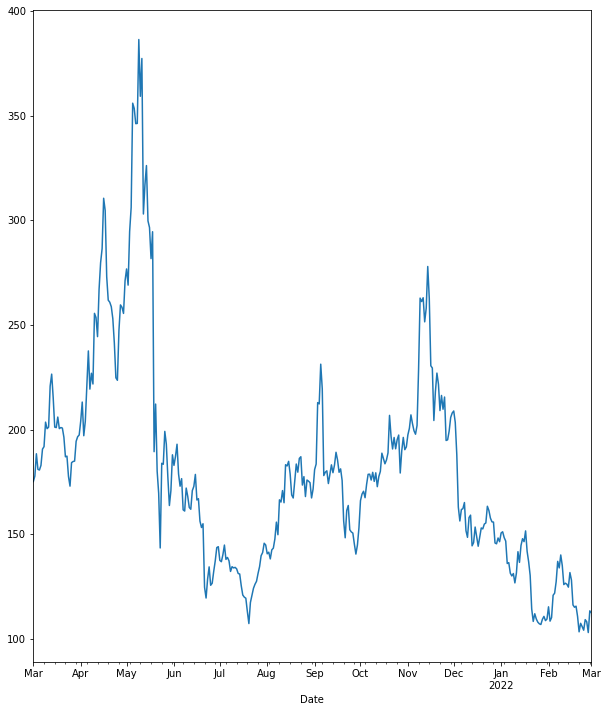

In [7]:
data['Adj Close'].plot(figsize=(10, 12), subplots=True)

# Binomial Method


In [9]:
import numpy as np
import os

In [10]:
S0 = 112                # spot stock price
K = 100                 # strike
T = 1/12                # maturity 
r = 0.0172              # risk free rate 
sig = 1.13              # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

In [12]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [13]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [14]:
S

array([[112.        , 135.21041635, 163.23086329, 197.05815166],
       [  0.        ,  92.77391742, 112.        , 135.21041635],
       [  0.        ,   0.        ,  76.84821208,  92.77391742],
       [  0.        ,   0.        ,   0.        ,  63.65633644]])

In [15]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4543166134306948

In [16]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  7.22608258],
       [ 0.        ,  0.        ,  0.        , 36.34366356]])

In [17]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 8.82543977,  2.1496581 ,  0.        ,  0.        ],
       [ 0.        , 14.3911876 ,  3.94126971,  0.        ],
       [ 0.        ,  0.        , 23.10402156,  7.22608258],
       [ 0.        ,  0.        ,  0.        , 36.34366356]])

In [18]:
print('European ' + payoff, str( V[0,0]))

European put 8.825439770058871


# Monte Carlo 


In [19]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [20]:
T = 1/12
r = 0.0172
sigma = 1.13
S0 = 112
K = 100

In [21]:
S = mcs_simulation_np(10000)

In [22]:
S = np.transpose(S)
S

array([[112.        , 112.55865651, 112.300205  , ..., 192.68736351,
        192.65520323, 193.83633834],
       [112.        , 112.23806024, 112.63673823, ...,  87.65961362,
         87.32470215,  87.17568026],
       [112.        , 111.86486271, 111.51634542, ...,  44.81774124,
         44.68481823,  44.5987824 ],
       ...,
       [112.        , 111.65485873, 111.54351828, ..., 114.03023556,
        114.43284545, 113.9226375 ],
       [112.        , 112.41845014, 112.15665316, ...,  95.76426232,
         96.04988754,  96.79038928],
       [112.        , 112.43872428, 111.94147024, ..., 108.55939226,
        108.88860296, 108.56254731]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values of LTC-USD')

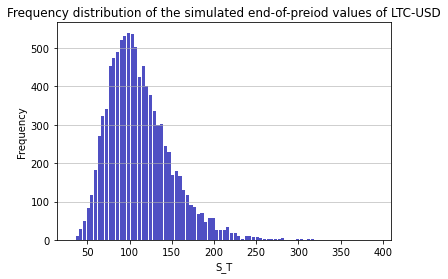

In [23]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values of LTC-USD')


In [24]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 8.569631413827175


In [25]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 20.333490968444632


# Black - Scholes

In [112]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [113]:
S = 112
K = 140
T = 1/12
r = 0.0172

In [28]:
call = euro_option_bs(S, K, T, r, vol_h, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 5.99


In [29]:
put = euro_option_bs(S, K, T, r, vol_h, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 33.79


In [36]:
S = np.linspace(30,230,101)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 140, 1/12, 0.0172, 1.13, 'call')

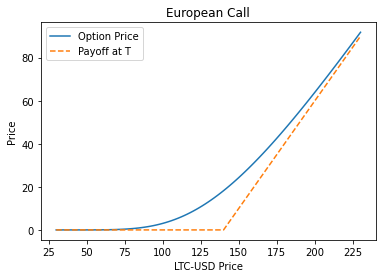

In [37]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-140,0), '--')
plt.xlabel('LTC-USD Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [40]:
S = np.linspace(30,230,101)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 100, 1/12, 0.0172, 1.13, 'put')

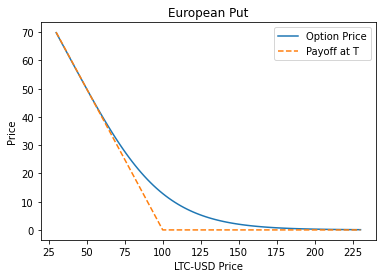

In [41]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(100-S,0), '--')
plt.xlabel('LTC-USD Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

# Greeks
Delta 

In [42]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [43]:
delta(112, 140, 1/12, 0.0172, 0, 1.13, 'call')

0.30272880382931955

In [44]:
delta(112, 100, 1/12, 0.0172, 0, 1.13, 'put')

-0.30330683269384545

In [45]:
S = np.linspace(30,230,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 140, 1/12, 0.0172, 0, 1.13, 'call')
    Delta_Put [i] = delta(S[i], 100, 1/12, 0.0172, 0, 1.13, 'put')

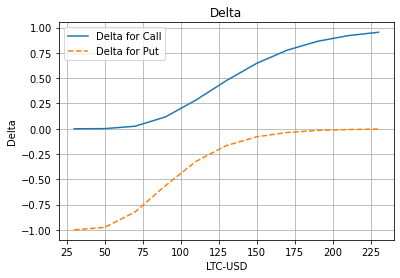

In [46]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('LTC-USD')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [80]:
S = np.linspace(30, 230, 51)
T = np.linspace(0.01, 0.30, 30)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 140, T[i], 0.0172, 0, 1.13, 'call')

C:\Users\Dell\AppData\Local\Temp/ipykernel_15376/1919612790.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


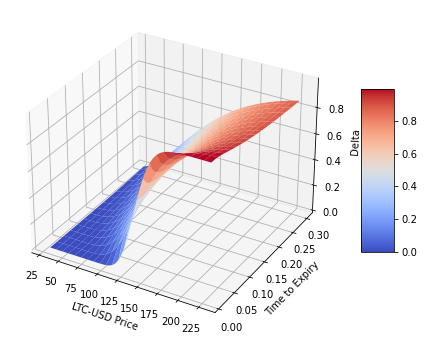

In [81]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LTC-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [82]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [83]:
gamma(112, 140, 1/12, 0.0172, 0, 1.13, 'call')

0.009555646206138132

In [84]:
gamma(112, 100, 1/12, 0.0172, 0, 1.13, 'put')

0.009563805921372813

In [85]:
S = np.linspace(30,230,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 140, 1/12, 0.0172, 0, 1.13, 'call')

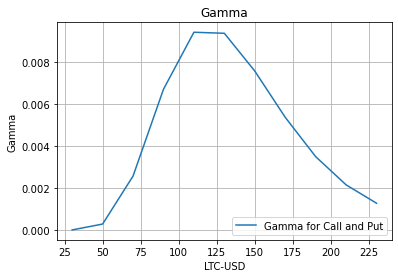

In [86]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('LTC-USD')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Surface of Gamma

In [87]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [88]:
S = np.linspace(30, 230, 51)
T = np.linspace(0.01, 0.30, 30)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 140, T[i], 0.0172, 0, 1.13, 'call')

C:\Users\Dell\AppData\Local\Temp/ipykernel_15376/2848842567.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


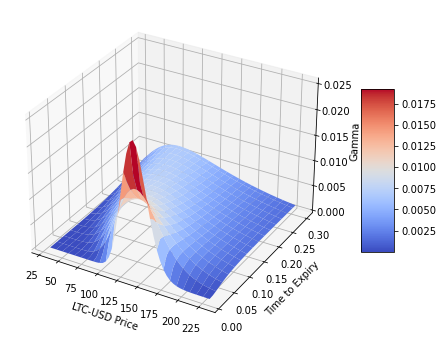

In [89]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LTC-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed


In [90]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [91]:
speed(112, 140, 1/12, 0.0172, 0, 1.13, 'call')

1.4373132058534727e-05

In [92]:
speed(112, 140, 1/12, 0.0172, 0, 1.13, 'put')

1.4373132058534727e-05

In [93]:
S = np.linspace(30,230,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 140, 1/12, 0.0172, 0, 1.13, 'call')

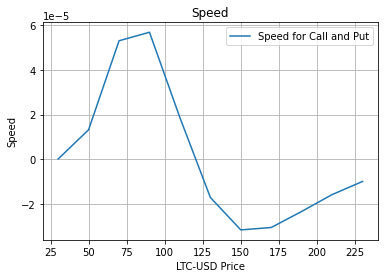

In [94]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('LTC-USD Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Surface of Speed

In [95]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [96]:
S = np.linspace(30, 230, 101)
T = np.linspace(0.01, 0.30, 30)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 140, T[i], 0.0172, 0, 1.13, 'call')

C:\Users\Dell\AppData\Local\Temp/ipykernel_15376/2308886909.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


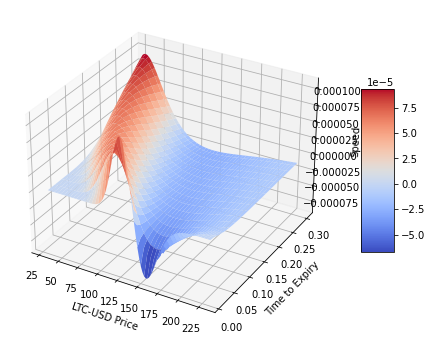

In [97]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LTC-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [75]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [76]:
theta(112, 140, 1/12, 0.0172, 0, 1.13, 'call')

77.00860079906487

In [77]:
theta(112, 100, 1/12, 0.0172, 0, 1.13, 'put')

77.32404083051892

In [98]:
T = np.linspace(0.01, 0.30, 30)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(112, 140, T[i], 0.0172, 0, 1.13, 'call')
    Theta_Put [i] = theta(112, 100, T[i], 0.0172, 0, 1.13, 'put')

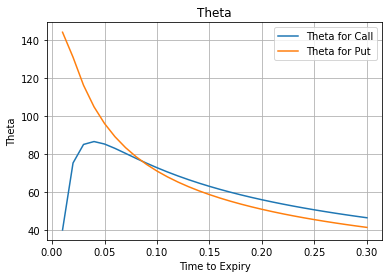

In [99]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# Surface of Theta

In [100]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [101]:
S = np.linspace(30, 230, 101)
T = np.linspace(0.01, 0.30, 30)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 140, T[i], 0.0172, 0, 1.13, 'call')

C:\Users\Dell\AppData\Local\Temp/ipykernel_15376/168568528.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


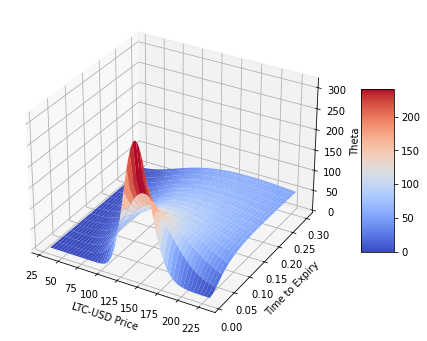

In [102]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LTC-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [103]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [104]:
rho(112, 140, 1/12, 0.0172, 0, 1.13, 'call')

2.3262426991770697

In [105]:
rho(112, 100, 1/12, 0.0172, 0, 1.13, 'put')

-3.537924787214195

In [106]:
r = np.linspace(0,0.1,50)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(112, 140, 1/12, r[i], 0, 1.13, 'call')
    Rho_Put [i] = rho(112, 100, 1/12, r[i], 0, 1.13, 'put')

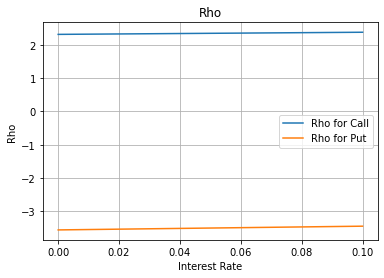

In [107]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

# Surface of Rho


In [108]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [109]:
S = np.linspace(30, 230, 101)
T = np.linspace(0.01, 0.30, 30)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 140, T[i], 0.0172, 0, 1.13, 'call')

C:\Users\Dell\AppData\Local\Temp/ipykernel_15376/3521907160.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


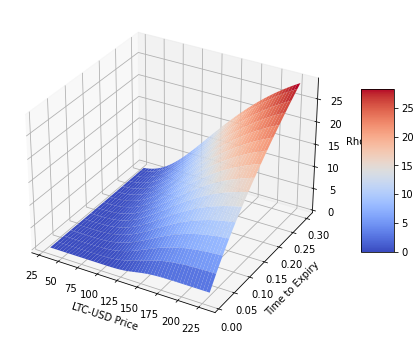

In [110]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('LTC-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);